# Week 10 Assignment: Sentiment Analysis

**Brian Roepke**  
*DATA 110*

For the given dataset perform sentiment analysis using  1) Machine Learning and 2) Lexicon-based techniques.  Refer to assigned reading (especially ch 7), supplementals, or conduct your own research.

Requirements:

1) Perform full EDA,  including key statistics and visualizations.

2) Perform required text preprocessing and feature vectorization (Eg: TF-IDF)

3) Modeling: Create ML and Lexicon-based models.

 a) Machine learning:

 - create a new column (sent_label) for the target based on reviews.rating, where  1, 2, or 3 are labeled as 0 (negative) while 4 or greater are labeled as 1 (positive)

- Use any appropriate ML algorithm (eg: SVM, Logistic Regression, etc...)  and create 3 different models using pipelines. 

- Use cross-validation (StratifiedKFold for imbalanced datasets) to compare each of the models for model selection.

- Consider the case of imbalanced dataset (Eg: significantly more positive reviews versus negative reviews). 



b) Lexicon: use any of the lexicons such as VADER or SentiWordNet.

4) Assess performance using appropriate performance metrics. Compare performance between the two approaches.

5) For both approaches, provide visualizations of the most common words in negative and positive reviews.  These can be bar plots, word clouds, etc.

In [1]:
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("Amazon_Consumer_Reviews.csv")

# EDA

In [4]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  28332 non-null  object 
 1   dateAdded           28332 non-null  object 
 2   dateUpdated         28332 non-null  object 
 3   name                28332 non-null  object 
 4   asins               28332 non-null  object 
 5   brand               28332 non-null  object 
 6   categories          28332 non-null  object 
 7   primaryCategories   28332 non-null  object 
 8   keys                28332 non-null  object 
 9   manufacturer        28332 non-null  object 
 10  manufacturerNumber  28332 non-null  object 
 11  reviews.date        28332 non-null  object 
 12  reviews.dateSeen    28332 non-null  object 
 13  reviews.numHelpful  16115 non-null  float64
 14  reviews.rating      28332 non-null  int64  
 15  reviews.sourceURLs  28332 non-null  object 
 16  revi

In [8]:
df.describe()

,reviews.numHelpful,reviews.rating
count,16115.000000,28332.000000
mean,0.529321,4.514048
std,9.345017,0.934957
min,0.000000,1.000000
25%,0.000000,4.000000
50%,0.000000,5.000000
75%,0.000000,5.000000
max,621.000000,5.000000


In [10]:
df.shape

(28332, 19)

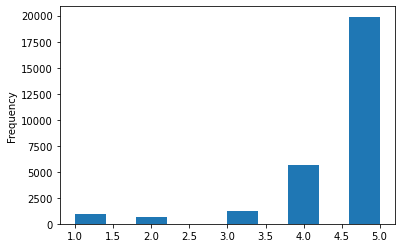

In [17]:
df['reviews.rating'].plot(kind='hist');

# Preprocessing

# Machine learning